In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

In [2]:
# Data taken from https://www.kaggle.com/shahir/protein-data-set
# This is a protein data set retrieved from Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB).

In [3]:
df1 = pd.read_csv('pdb_data_no_dups.csv')
df2 = pd.read_csv('pdb_data_seq.csv')
df1.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [4]:
df2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
df1.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [6]:
df2.columns

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')

In [7]:
df1.shape

(141401, 14)

In [8]:
df2.shape

(467304, 5)

In [9]:
df3 = pd.merge(df1, df2, on=['structureId','macromoleculeType','residueCount'])

In [10]:
df3.shape

(471149, 16)

In [11]:
df3.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [12]:
df3.tail()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.9,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471148,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,D,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


In [13]:
df3.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
dtype: object

In [14]:
df3.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [15]:
mask = df3['macromoleculeType'] == 'Protein'

In [16]:
proteins = df3[mask]
proteins.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [17]:
proteins.shape

(346325, 16)

In [18]:
# Sanity check for protein sequences only
proteins.macromoleculeType.value_counts()

Protein    346325
Name: macromoleculeType, dtype: int64

In [19]:
proteins['sequence'].head(3)

4    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7    MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
Name: sequence, dtype: object

## Classification of Proteins: Logistic Regression Model

In [20]:
proteins.classification.value_counts()[:35]

HYDROLASE                                  46336
TRANSFERASE                                36424
OXIDOREDUCTASE                             34322
IMMUNE SYSTEM                              15615
LYASE                                      11682
HYDROLASE/HYDROLASE INHIBITOR              11218
TRANSCRIPTION                               8919
VIRAL PROTEIN                               8495
TRANSPORT PROTEIN                           8371
VIRUS                                       6972
SIGNALING PROTEIN                           6470
ISOMERASE                                   6356
LIGASE                                      4964
MEMBRANE PROTEIN                            4891
PROTEIN BINDING                             4884
STRUCTURAL PROTEIN                          4335
CHAPERONE                                   4156
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       3548
SUGAR BINDING PROTEIN                       3474
DNA BINDING PROTEIN                         3199
PHOTOSYNTHESIS      

In [21]:
proteins.classification.value_counts()[92:122]

ENDOCYTOSIS/EXOCYTOSIS                      217
Hydrolase/Hydrolase inhibitor               217
MEMBRANE PROTEIN, TRANSPORT PROTEIN         215
ISOMERASE/ISOMERASE INHIBITOR               212
IMMUNE SYSTEM/VIRAL PROTEIN                 210
VIRUS/IMMUNE SYSTEM                         203
TRANSFERASE/ANTIBIOTIC                      202
TRANSCRIPTION REGULATION                    197
Structural Genomics, Unknown function       195
RECOMBINATION                               192
DIOXYGENASE                                 189
HYDROLASE/PEPTIDE                           188
IRON STORAGE                                187
RIBOSOMAL PROTEIN                           187
HYDROLASE(O-GLYCOSYL)                       180
PHOSPHOTRANSFERASE                          180
ACETYLCHOLINE-BINDING PROTEIN               180
Structural genomics, unknown function       166
ELECTRON TRANSPORT,PHOTOSYNTHESIS           160
TRANSPORT                                   160
ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE)

## 5 Classes of Proteins

In [22]:
mask = ((proteins.classification == 'HYDROLASE') | (proteins.classification == 'TRANSFERASE')\
      |(proteins.classification == 'IMMUNE SYSTEM')\
      | (proteins.classification == 'ISOMERASE') |(proteins.classification == 'LIGASE'))

data = proteins[mask]
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
74,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
75,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...


In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.classification)
data['type'] = le.transform(data['classification'])

/Users/scottlew/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
74,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3
75,11AS,LIGASE,X-RAY DIFFRACTION,Protein,660,2.50,73530.97,NaN,NaN,2.30,47.00,PROTEIN CRYSTALLIZED FROM 45% SATURATED AMMONI...,7.5,1998.0,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,0


In [25]:
data.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'type'],
      dtype='object')

In [26]:
data.classification.value_counts()

HYDROLASE        46336
TRANSFERASE      36424
IMMUNE SYSTEM    15615
ISOMERASE         6356
LIGASE            4964
Name: classification, dtype: int64

In [27]:
data.type.value_counts()

0    46336
4    36424
1    15615
2     6356
3     4964
Name: type, dtype: int64

In [28]:
# permute/scramble/shuffle rows of the dataframe
data = data.sample(frac=1)
data.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
72795,1XVM,HYDROLASE,X-RAY DIFFRACTION,Protein,227,1.10,22503.83,"VAPOR DIFFUSION, SITTING DROP",293.0,2.00,38.43,"ammonium sulfate, sodium citrate, pH 5, VAPOR ...",5.0,2005.0,B,GAR,0
127792,2UBP,HYDROLASE,X-RAY DIFFRACTION,Protein,793,2.00,86576.30,NaN,NaN,2.70,54.00,"53% SATURATED AMMONIUM SULPHATE, 1.2 M LICL, 2...",6.3,1999.0,A,XMHLNPAEKEKLQIFLASELLLRRKARGLKLNYPEAVAIITSFIME...,0
219156,3QR9,TRANSFERASE,X-RAY DIFFRACTION,Protein,754,1.87,77803.75,"VAPOR DIFFUSION, HANGING DROP",291.0,2.83,56.50,"0.2M imidazole malate, 15% PEG4000, pH 8.0, VA...",8.0,2013.0,B,ALSAEGSSGGSRGGSPKAEAASVPSWPQILGRLTDNRDLARGQAAW...,4


In [29]:
data.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
type                          int64
dtype: object

In [30]:
#data.isna.sum()
data.isnull().sum(axis = 0)

structureId                     0
classification                  0
experimentalTechnique           0
macromoleculeType               0
residueCount                    0
resolution                   1567
structureMolecularWeight        0
crystallizationMethod       26937
crystallizationTempK        26065
densityMatthews              5498
densityPercentSol            5462
pdbxDetails                  8929
phValue                     21930
publicationYear             18657
chainId                         1
sequence                        0
type                            0
dtype: int64

In [31]:
data.shape

(109695, 17)

In [32]:
seqs = data.sequence
print(len(seqs))

109695


In [33]:
unique_seqs = list(set(seqs))
print(len(unique_seqs))

30529


In [34]:
# remove the duplicate protein sequences
data = data.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
data = data[data['sequence'].notnull()]
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
72795,1XVM,HYDROLASE,X-RAY DIFFRACTION,Protein,227,1.10,22503.83,"VAPOR DIFFUSION, SITTING DROP",293.0,2.00,38.43,"ammonium sulfate, sodium citrate, pH 5, VAPOR ...",5.0,2005.0,B,GAR,0
127792,2UBP,HYDROLASE,X-RAY DIFFRACTION,Protein,793,2.00,86576.30,NaN,NaN,2.70,54.00,"53% SATURATED AMMONIUM SULPHATE, 1.2 M LICL, 2...",6.3,1999.0,A,XMHLNPAEKEKLQIFLASELLLRRKARGLKLNYPEAVAIITSFIME...,0
219156,3QR9,TRANSFERASE,X-RAY DIFFRACTION,Protein,754,1.87,77803.75,"VAPOR DIFFUSION, HANGING DROP",291.0,2.83,56.50,"0.2M imidazole malate, 15% PEG4000, pH 8.0, VA...",8.0,2013.0,B,ALSAEGSSGGSRGGSPKAEAASVPSWPQILGRLTDNRDLARGQAAW...,4
216875,3Q37,ISOMERASE,X-RAY DIFFRACTION,Protein,1004,1.65,109288.98,"VAPOR DIFFUSION, SITTING DROP",278.0,2.26,45.48,"0.2 Sodium malonate, 20% PEG 3350, pH 7.0, VAP...",7.0,2011.0,A,MASKPQPIAAANWKCNGSQQSLSELIDLFNSTSINHDVQCVVAPTF...,2
67896,1W4R,TRANSFERASE,X-RAY DIFFRACTION,Protein,1560,1.83,178842.28,NaN,NaN,2.40,48.00,pH 7.20,7.2,2005.0,D,MRGSHHHHHHLVPRGSKTRGQIQVILGPMFSGKSTELMRRVRRFQI...,4


In [35]:
data.shape

(30529, 17)

## Load additional isomerase & ligase protein sequences from csv files

In [36]:
isomerase = pd.read_csv('uniprot-isomerase.csv')

isomerase.head()

,name,sequence,classification,type
0,sp|P61615|IDI2_SACSH,MPDIVNRKVEHVEIAAFENVDGLSSSTFLNDVILVHQGFPGISFSE...,ISOMERASE,2
1,sp|Q746I8|IDI2_THET2,MNIRERKRKHLEACLEGEVAYQKTTTGLEGFRLRYQALAGLALGEV...,ISOMERASE,2
2,sp|Q8ZWV0|PGMI_PYRAE,MSQLLQDYLNWENYILRRVDFPTSYVVEGEVVRIEAMPRLYISGMG...,ISOMERASE,2
3,sp|P42126|ECI1_HUMAN,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,ISOMERASE,2
4,sp|Q9WUR2|ECI2_MOUSE,MAAVTWSRARCWCPSVLQVFRLQVAKLHLGRPTMRASQQDFENALN...,ISOMERASE,2


In [37]:
isomerase.columns = ['structureId', 'sequence', 'classification', 'type']
isomerase.head()

,structureId,sequence,classification,type
0,sp|P61615|IDI2_SACSH,MPDIVNRKVEHVEIAAFENVDGLSSSTFLNDVILVHQGFPGISFSE...,ISOMERASE,2
1,sp|Q746I8|IDI2_THET2,MNIRERKRKHLEACLEGEVAYQKTTTGLEGFRLRYQALAGLALGEV...,ISOMERASE,2
2,sp|Q8ZWV0|PGMI_PYRAE,MSQLLQDYLNWENYILRRVDFPTSYVVEGEVVRIEAMPRLYISGMG...,ISOMERASE,2
3,sp|P42126|ECI1_HUMAN,MALVASVRVPARVLLRAGARLPGAALGRTERAAGGGDGARRFGSQR...,ISOMERASE,2
4,sp|Q9WUR2|ECI2_MOUSE,MAAVTWSRARCWCPSVLQVFRLQVAKLHLGRPTMRASQQDFENALN...,ISOMERASE,2


In [38]:
ligase = pd.read_csv('uniprot-ligase.csv')
ligase.columns = ['structureId', 'sequence', 'classification', 'type']
ligase.head()

,structureId,sequence,classification,type
0,sp|P50747|BPL1_HUMAN,MEDRLHMDNGLVPQKIVSVHLQDSTLKEVKDQVSNKQAQILEPKPE...,LIGASE,3
1,sp|O14975|S27A2_HUMAN,MLSAIYTVLAGLLFLPLLVNLCCPYFFQDIGYFLKVAAVGRRVRSY...,LIGASE,3
2,sp|P97524|S27A2_RAT,MLPVLYTGLAGLLLLPLLLTCCCPYLLQDVRFFLQLANMARQVRSY...,LIGASE,3
3,sp|O35488|S27A2_MOUSE,MLPVLYTGLAGLLLLPLLLTCCCPYLLQDVRYFLRLANMARRVRSY...,LIGASE,3
4,sp|P33121|ACSL1_HUMAN,MQAHELFRYFRMPELVDFRQYVRTLPTNTLMGFGAFAALTTFWYAT...,LIGASE,3


In [39]:
df_1 = data[['structureId', 'sequence', 'classification', 'type']]
df_1.shape

(30529, 4)

In [40]:
df_1.head()

,structureId,sequence,classification,type
72795,1XVM,GAR,HYDROLASE,0
127792,2UBP,XMHLNPAEKEKLQIFLASELLLRRKARGLKLNYPEAVAIITSFIME...,HYDROLASE,0
219156,3QR9,ALSAEGSSGGSRGGSPKAEAASVPSWPQILGRLTDNRDLARGQAAW...,TRANSFERASE,4
216875,3Q37,MASKPQPIAAANWKCNGSQQSLSELIDLFNSTSINHDVQCVVAPTF...,ISOMERASE,2
67896,1W4R,MRGSHHHHHHLVPRGSKTRGQIQVILGPMFSGKSTELMRRVRRFQI...,TRANSFERASE,4


In [41]:
# scramble isomerase sequences in dataframe
isomerase = isomerase.sample(frac=1)
isomerase.head(3)

,structureId,sequence,classification,type
11698,sp|B1GZN9|TRUB_UNCTG,MSQSYNNIDGLLLLDKPFGITSFDAVYKIKKVLNVEKTGHCGTLDP...,ISOMERASE,2
709,sp|Q9PR63|GYRA_UREPA,MALKKPKKSRLTTEEIKQQLEGSTIKEQSITKEVETSFLDYSMSVI...,ISOMERASE,2
8454,sp|Q4KIF9|TPIS_PSEF5,MRRPMVAGNWKMHGTRASVAELINGLRHLALPSGVDVAVFPPCLYI...,ISOMERASE,2


In [42]:
isomerase.shape

(15534, 4)

In [43]:
ligase.shape

(32792, 4)

## Add more protein sequences

In [44]:
tf = pd.read_csv('uniprot-transferase-reviewed.csv')
tf.head()

,name,sequence,classification,type
0,sp|Q8CFC4|BGAT2_RAT,MKDLRFGRLKCYSLHLGILPLTVLVLVFFCFVCLSLRSQEWGHPGA...,TRANSFERASE,4
1,sp|Q9ET32|BGAT1_RAT,MDLRGRPKCYSLHLGILPFIVLVLVFFGYGFLSHKIQEFRNPGGET...,TRANSFERASE,4
2,sp|P16442|BGAT_HUMAN,MAEVLRTLAGKPKCHALRPMILFLIMLVLVLFGYGVLSPRSLMPGS...,TRANSFERASE,4
3,sp|P38649|BGAT_MOUSE,MNLRGRPKCNFLHLGILPFAVFVLVFFGYLFLSFRSQNLGHPGAVT...,TRANSFERASE,4
4,sp|P0AC75|KDTA_ECOLI,MLELLYTALLYLIQPLIWIRLWVRGRKAPAYRKRWGERYGFYRHPL...,TRANSFERASE,4


In [45]:
tf.shape

(86338, 4)

In [46]:
tf2 = tf.sample(frac=0.33)
tf2.shape

(28492, 4)

In [47]:
df_3 = pd.concat([df_1,isomerase,ligase,tf2])
df_3.shape

/Users/scottlew/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


(107347, 5)

In [48]:
df_3.classification.value_counts()

TRANSFERASE      37768
LIGASE           34311
ISOMERASE        17139
HYDROLASE        12668
IMMUNE SYSTEM     5461
Name: classification, dtype: int64

In [49]:
df_3.type.value_counts()

4    37768
3    34311
2    17139
0    12668
1     5461
Name: type, dtype: int64

## Remove Duplicate Sequences

In [50]:
# remove the duplicate protein sequences
df_3 = df_3.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
df_3 = df_3[df_3['sequence'].notnull()]
df_3.head()

,classification,name,sequence,structureId,type
72795,HYDROLASE,NaN,GAR,1XVM,0
127792,HYDROLASE,NaN,XMHLNPAEKEKLQIFLASELLLRRKARGLKLNYPEAVAIITSFIME...,2UBP,0
219156,TRANSFERASE,NaN,ALSAEGSSGGSRGGSPKAEAASVPSWPQILGRLTDNRDLARGQAAW...,3QR9,4
216875,ISOMERASE,NaN,MASKPQPIAAANWKCNGSQQSLSELIDLFNSTSINHDVQCVVAPTF...,3Q37,2
67896,TRANSFERASE,NaN,MRGSHHHHHHLVPRGSKTRGQIQVILGPMFSGKSTELMRRVRRFQI...,1W4R,4


In [51]:
df_3.shape

(104902, 5)

## Classifier of Protein Sequences: Predict 5 Classes

## CountVectorizer: Count peptide frequency, transform the data

In [52]:
# In this case, hexapeptide frequency is used for analysis
vect_ = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(6,6))

## Split the data into training & test sets for classification model

In [53]:
X = vect_.fit_transform(df_3.sequence)
y = df_3.type

In [54]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(83921, 14257970) (83921,)
(20981, 14257970) (20981,)


In [55]:
y_test.value_counts()

4    7066
3    6746
2    3566
0    2513
1    1090
Name: type, dtype: int64

## MNB Classifier Model

In [56]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("MNB classifier Score: {:.2f}".format(mnb.score(X_test, y_test)))
print()

MNB classifier Score: 0.82



## MNB Classifier Optimization

In [57]:
#alphas = np.arange(0.1,5.5,0.1)
alphas = np.arange(36,40,0.5)
# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    nb_op = MultinomialNB(alpha=alpha)
    nb_op.fit(X_train, y_train)
    print('Alpha: ', alpha)
    print('Score: ',nb_op.score(X_test, y_test) )
    print()

Alpha:  36.0
Score:  0.900624374434

Alpha:  36.5
Score:  0.901053333969

Alpha:  37.0
Score:  0.900910347457

Alpha:  37.5
Score:  0.900910347457

Alpha:  38.0
Score:  0.900862685287

Alpha:  38.5
Score:  0.900815023116

Alpha:  39.0
Score:  0.900815023116

Alpha:  39.5
Score:  0.900815023116



In [58]:
%%time
clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB(alpha=50)

eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.92

CPU times: user 1min 21s, sys: 5.04 s, total: 1min 26s
Wall time: 1min 25s


In [59]:
vote_prediction = eclf1.predict(X_test)
print(classification_report(vote_prediction, y_test))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      2244
           1       0.84      0.88      0.86      1046
           2       0.93      0.98      0.96      3370
           3       0.93      0.98      0.95      6355
           4       0.98      0.87      0.92      7966

    accuracy                           0.92     20981
   macro avg       0.89      0.92      0.91     20981
weighted avg       0.93      0.92      0.92     20981



In [60]:
# Generate Confusion Matrix for Voting Model
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Voting Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Voting Model

[[2008   28   20   34  423]
 [  44  918    2    3  123]
 [  27    9 3316   15  199]
 [  87   67   19 6245  328]
 [  78   24   13   58 6893]]


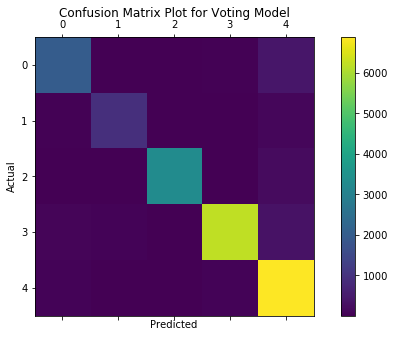

In [61]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Voting Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Cross Validation of Model

In [62]:
#instantiate a logistic regression classifier
clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB(alpha=50)

vote_cv = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
scores = cross_val_score(vote_cv,X,y, cv = 5)
print("Cross-validation scores for Voting Classifier: {}".format(scores))
print()
print("The average accuracy score for Voting Classifier is: ")
print(np.mean(scores))

Cross-validation scores for Voting Classifier: [ 0.79701649  0.91906963  0.93756256  0.93760427  0.90037657]

The average accuracy score for Voting Classifier is: 
0.898325903867
